In [1]:
import os
import sys

sys.path.append(os.path.abspath('./utils/'))

import cv2
import umap
import glob
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from PIL import Image
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances

from zps_matrix6 import ZPs
from key_points import KeyPoints

# Load Data

In [2]:
def get_data(img_path, json_path, patch_size=64, img_size=2048):
    with open(json_path) as f:
        data = json.load(f)
        
    img = np.array(Image.open(img_path))
    pts = np.array([item['points'][0] for item in data['shapes']], np.int32)
    lbs = np.array(['2' in item['label'] for item in data['shapes']], np.int32)
    lights = img[pts[:, 1], pts[:, 0]]
    
    idx = (pts[:, 0] > patch_size) & (pts[:, 1] > patch_size) & (pts[:, 0] < img_size-patch_size) & (pts[:, 1] < img_size-patch_size) & (lights > 200)
    pts = pts[idx]

    kp = KeyPoints(pts, img, patch_size)
    ps = kp.extract_patches(patch_size) 
    
    return img, pts, ps, lbs[idx], lights[idx]

In [3]:
img1, pts1, ps1, lbs1, light1 = get_data(
    '../data/Te-MoS2.jpg',
    '../data/Te-MoS2.json',
); n1 = len(ps1)

img2, pts2, ps2, lbs2, light2 = get_data(
    '../data/S-MoTe2.jpg',
    '../data/S-MoTe2.json',
); n2 = len(ps2)

In [4]:
ps = np.concatenate([ps1, ps2], axis=0)

# ZPs

In [5]:
zps = ZPs(n_max=10, size=ps.shape[1])
zps.fit(ps)
x = zps.moments
x_rot = x.rotinv()


pd.DataFrame(x_rot[:n1]).to_csv('./results/Te-MoS2_Zernike feature_raw data.csv', index=None)


pd.DataFrame(x_rot[n1:]).to_csv('./results/S-MoTe2_Zernike feature_raw data.csv', index=None)

In [6]:
def normalize_to_minus_one_to_one(column):
    min_val = column.min()
    max_val = column.max()
    
    if min_val == max_val:
        return np.zeros_like(column)
        
    normalized_column = 2 * (column - min_val) / (max_val - min_val) - 1
    return normalized_column

x_rot_minmax = normalize_to_minus_one_to_one(x_rot)
pd.DataFrame(x_rot_minmax[:n1]).to_csv('./results/Te-MoS2__Zernike feature_global normalization.csv')
pd.DataFrame(x_rot_minmax[n1:]).to_csv('./results/S-MoTe2__Zernike feature_global normalization.csv')

x_rot_minmax2 = np.apply_along_axis(normalize_to_minus_one_to_one, 0, x_rot)
pd.DataFrame(x_rot_minmax2[:n1]).to_csv('./results/Te-MoS2__Zernike feature_columnalminmax.csv')
pd.DataFrame(x_rot_minmax2[n1:]).to_csv('./results/S-MoTe2__Zernike feature_columnalminmax.csv')

# UMAP

In [7]:
colors = [
    "#FF7F0E",  # orange
    "#2CA02C",  # green
    "#FF7F0E",  # orange
]

In [8]:
is_train = False

In [9]:
reducer = umap.UMAP()

if is_train:
    # Train and Save UMAP Model
    reducer.fit(x_rot)
    with open('./ckpts/umap_model.pkl', 'wb') as f:
        pickle.dump(reducer, f)

else:
    # Load UMAP Pretrained Model
    with open('./ckpts/umap_model.pkl', 'rb') as f:
        reducer = pickle.load(f)

x_umap = reducer.transform(x_rot)

# KMeans

In [10]:
clu = KMeans(n_clusters=3, random_state=42)

if is_train:
    clu.fit(x_umap)
    with open('./ckpts/kmeans_model.pkl', 'wb') as f:
        pickle.dump(clu, f)
else:
    with open('./ckpts/kmeans_model.pkl', 'rb') as f:
        clu = pickle.load(f)

clu_class = clu.predict(x_umap)

# Save 

In [11]:
df = pd.DataFrame(x_umap)
df['x'] = np.concatenate([pts1, pts2])[:, 0]
df['y'] = np.concatenate([pts1, pts2])[:, 1]
df['cluster'] = clu_class
df['label'] = np.concatenate([lbs1, lbs2])
df['gray'] = np.concatenate([img1[pts1[:, 1], pts1[:, 0]], img2[pts2[:, 1], pts2[:, 0]]])
pd.DataFrame(df[:n1]).to_csv('./results/Te-MoS2-UMAP-based dimension-reduced K-means clustering.csv', index=None)
pd.DataFrame(df[n1:]).to_csv('./results/S-MoTe2-UMAP-based dimension-reduced K-means clustering.csv', index=None)

# PLOT

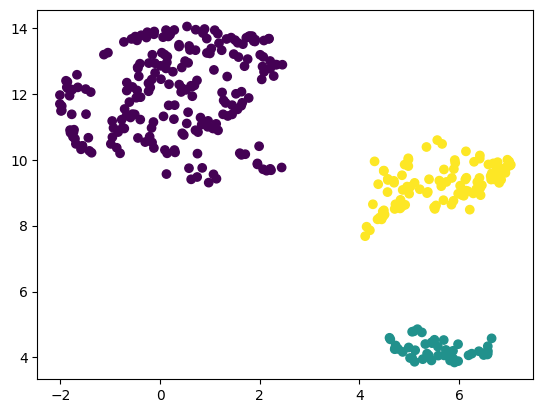

In [12]:
plt.scatter(x_umap[:, 0], x_umap[:, 1], c=clu_class)

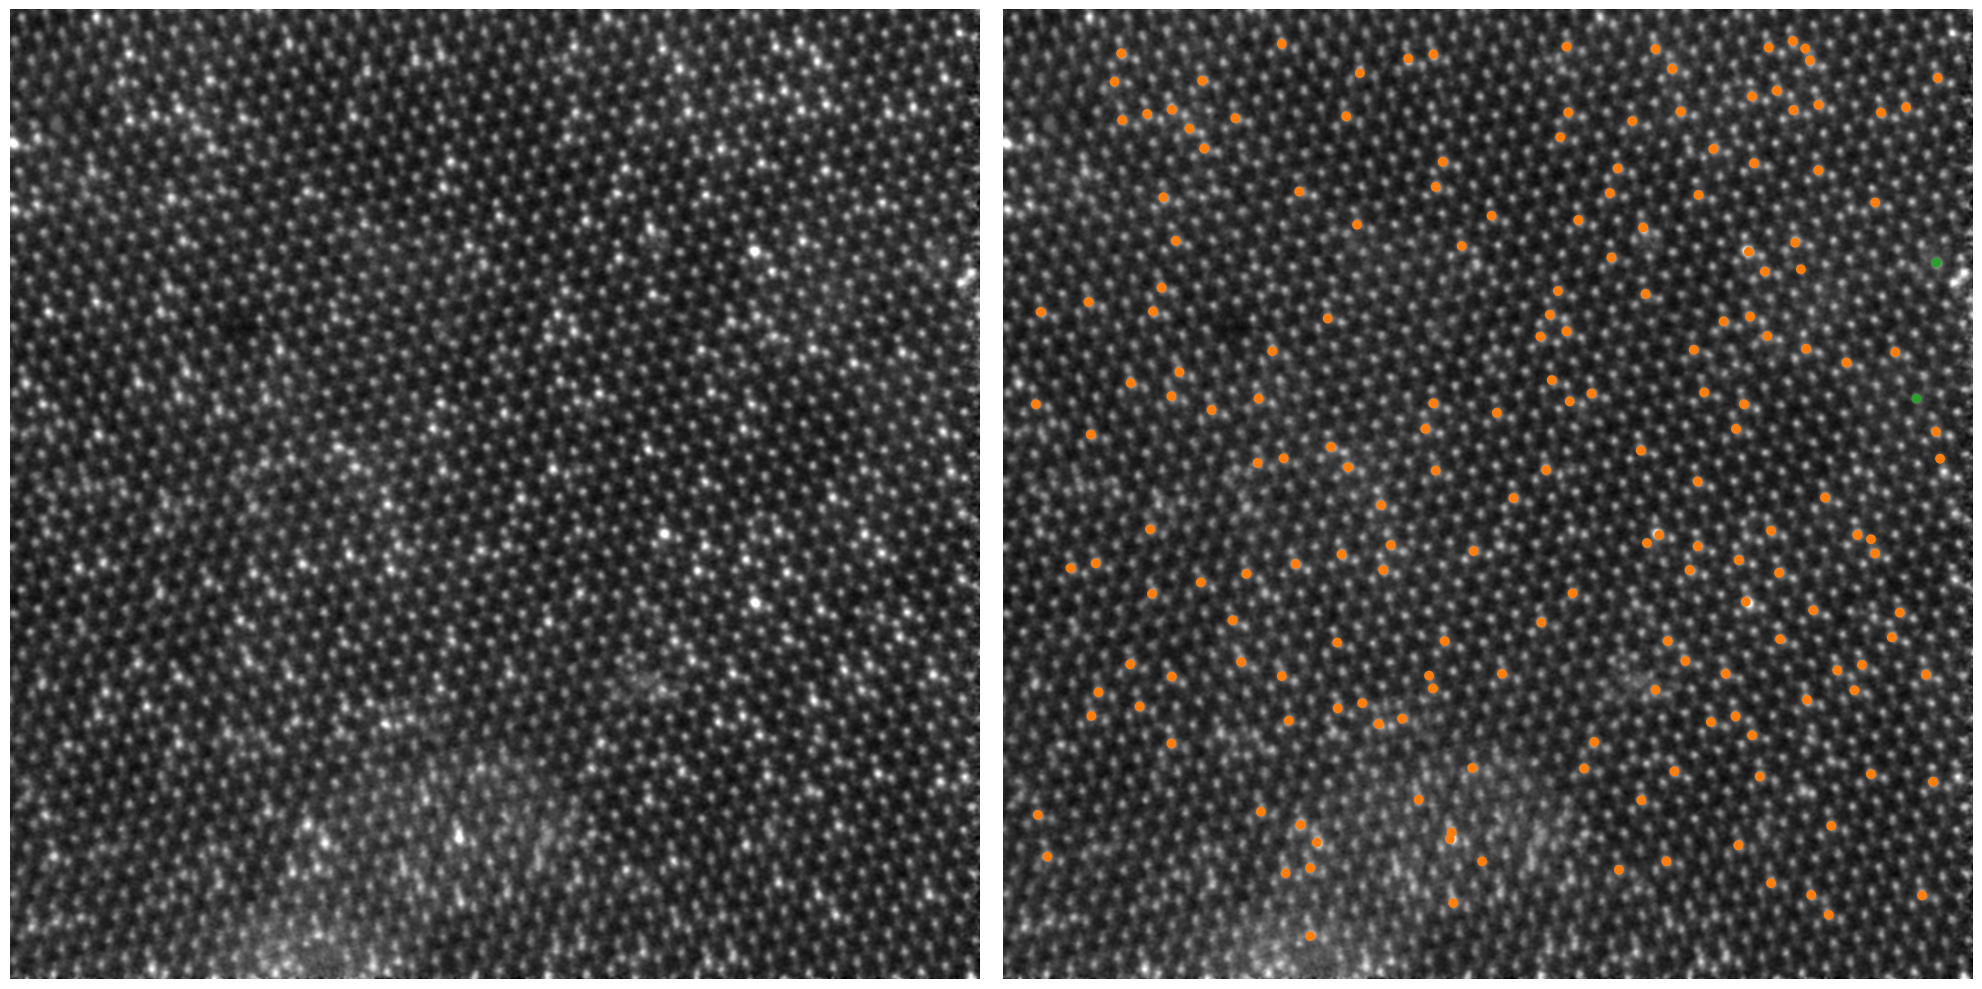

In [13]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(img1, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img1, cmap='gray')
plt.scatter(pts1[:, 0], pts1[:, 1], c=[colors[i] for i in clu_class[:n1]])
plt.axis('off')

plt.tight_layout()
plt.savefig('./results/Visualization of Te-MoS2.jpg', dpi=300)

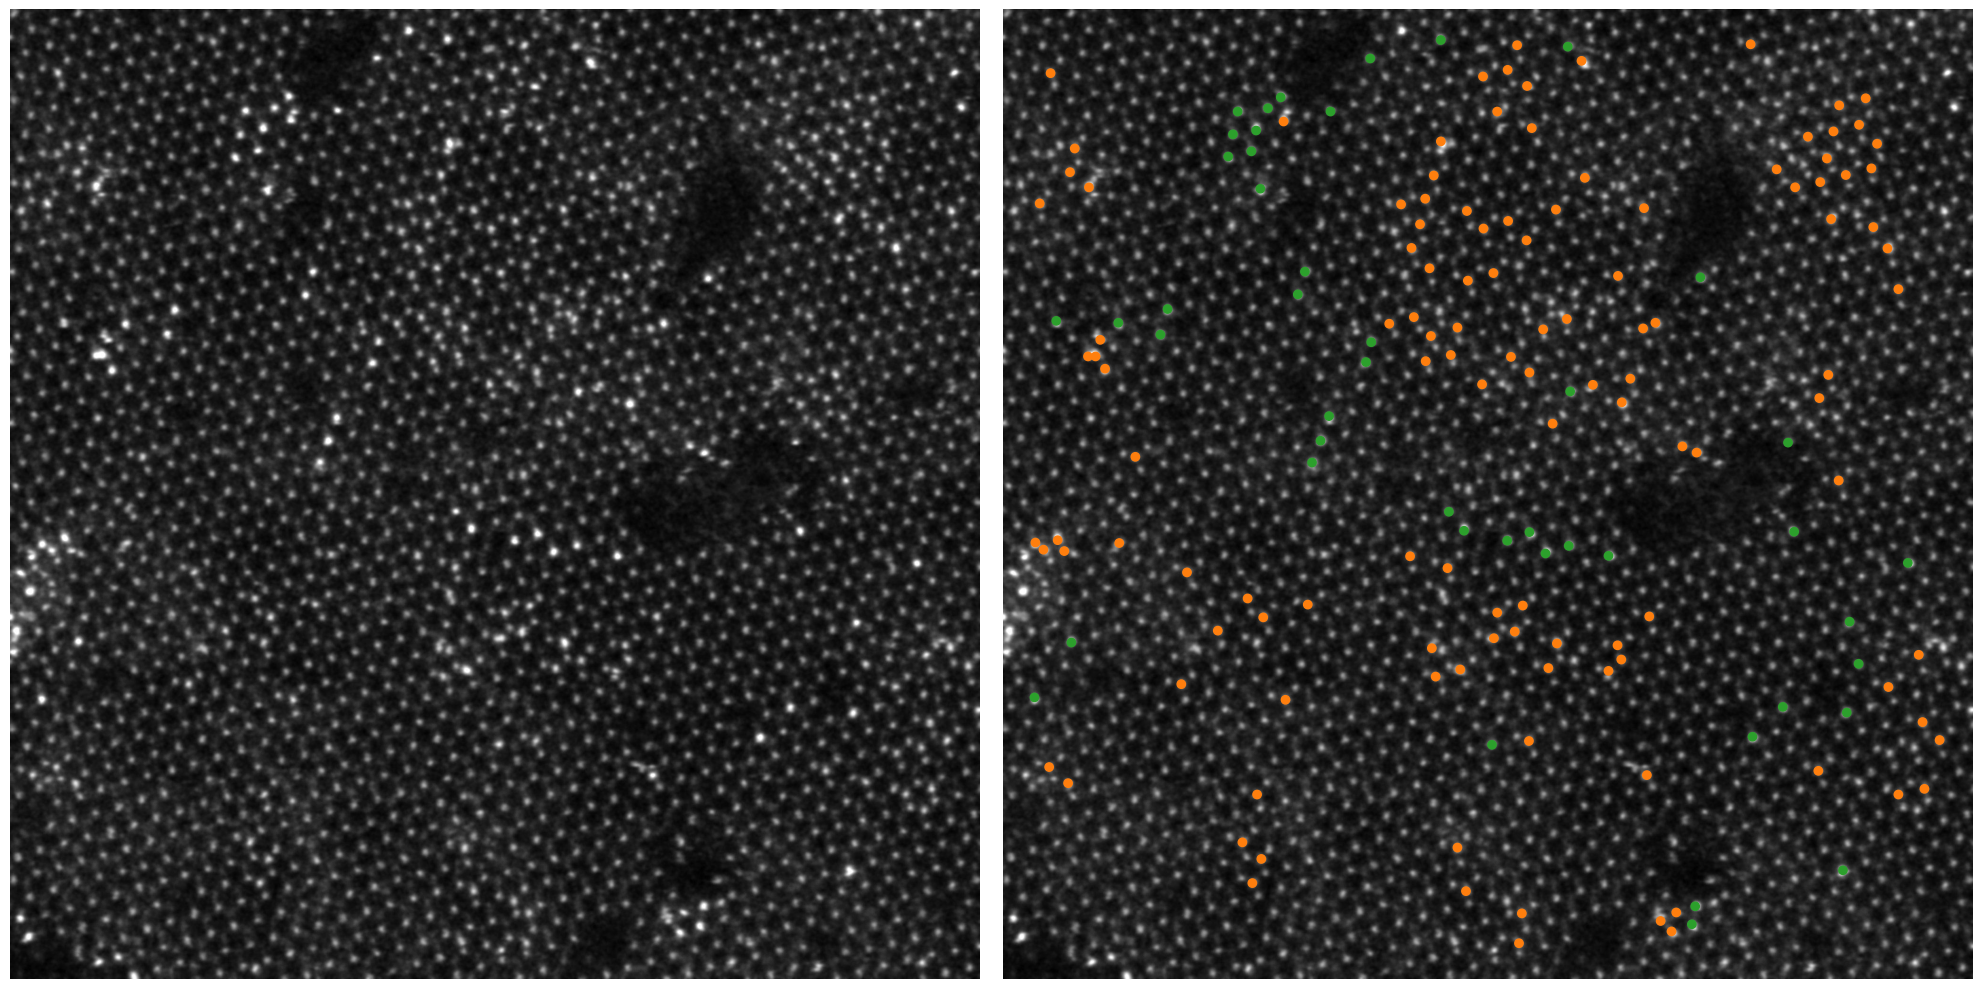

In [14]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(img2, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2, cmap='gray')
plt.scatter(pts2[:, 0], pts2[:, 1], c=[colors[i] for i in clu_class[n1:]])
plt.axis('off')

plt.tight_layout()
plt.savefig('./results/Visualization of S-MoTe2.jpg', dpi=300)